___
# **Starter code for BME 5710 project**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## BME5710 -- Spring 2025

___
### Import libraries and sub-libraries.

In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import pytorch_ssim
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import torch.nn.functional as F
from torchvision import transforms
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
from torch.optim.lr_scheduler import StepLR

# You can install torchmeterics using: pip install torchmetrics

___
### Calling a custom code to change the default font for figures to `Computer Modern`. (Optional)

In [2]:
from fontsetting import font_cmu
plt = font_cmu(plt)

___
### Check the hardware that is at your disposal

In [3]:
import torch

print("Torch version:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())
print("MPS built:", torch.backends.mps.is_built())

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)


Torch version: 2.5.1
MPS available: True
MPS built: True
Using device: mps


___
### Read training data from `data/train/hig-res` and `data/train/low-res`


In [4]:
# Loading TIFF images for Super-resolution
class TIFFDataset(Dataset):
    def __init__(self, high_res_dir, low_res_dir, transform=None):
        self.high_res_dir = high_res_dir
        self.low_res_dir = low_res_dir
        self.transform = transform
        self.filenames = sorted([f for f in os.listdir(high_res_dir) if f.endswith('.tif')])
    
    # Get the number of samples in the dataset
    def __len__(self):
        return len(self.filenames)

    # Get the sample at the given index
    def __getitem__(self, idx):
        high_res_path = os.path.join(self.high_res_dir, self.filenames[idx])
        low_res_path = os.path.join(self.low_res_dir, self.filenames[idx])

        # Load images
        high_res = Image.open(high_res_path)
        low_res = Image.open(low_res_path)

        # Resize low-res to 128x128 (ensuring correct input size)
        low_res = low_res.resize((128, 128), Image.BICUBIC)

        # Apply transformations
        if self.transform:
            high_res = self.transform(high_res)
            low_res = self.transform(low_res)

        return low_res, high_res  # Returning input-output pairs

# Define a transform to convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset for training images
train_dataset = TIFFDataset('data/train/high-res', 'data/train/low-res', transform=transform)

# Function to create data loader
def create_loader(dataset, batch_size):
    torch.manual_seed(0)  # For reproducibility
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Print dataset size
dataset_size = len(train_dataset)
print('Number of images in the dataset:', dataset_size)





Number of images in the dataset: 240


___
### Define a super-resolution network

#### Here, I have defined a trivial network, which has only two layers and no activation function. We are essentially doing linear filtering.

In [20]:
# class TrivialNet(nn.Module):
#     def __init__(self):
#         super(TrivialNet, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=12, out_channels=1, kernel_size=3, padding=1)

#     def forward(self, x):
#         x = self.conv1(x)  # First conv layer
#         x = self.conv2(x)  # Output layer
#         return x




import torch.nn as nn

class TrivialNet(nn.Module):
    def __init__(self):
        super(TrivialNet, self).__init__()
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.gelu1 = nn.GELU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.gelu2 = nn.GELU()
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.gelu1(self.conv1(x))
        x = self.gelu2(self.conv2(x))
        x = self.conv3(x)
        return x

    

# class TrivialNet(nn.Module):
#     def __init__(self):
#         super(TrivialNet, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.conv1(x))
#         x = self.conv2(x)
#         return x

    

#     # Define the SRCNN model
# class SRCNN(nn.Module):
#     def __init__(self):
#         super(SRCNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
#         self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
#         self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)

#     def forward(self, x):
#         x = torch.relu(self.conv1(x))
#         x = torch.relu(self.conv2(x))
#         x = self.conv3(x)
#         return x

# # Replace the TrivialNet with SRCNN in your code
# model = SRCNN().to(device)

###batch normlaization 
# class TrivialNet(nn.Module):
#     def __init__(self):
#         super(TrivialNet, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)  # 👈 Add this
#         self.relu = nn.ReLU()
#         self.conv2 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)  # 👈 Normalize before activation
#         x = self.relu(x)
#         x = self.conv2(x)
#         return x


___
### Create a function to execute training. Note, we will call this function later.

In [21]:
def train_model(model, opt, criterion, train_loader, num_epoch, scheduler):
    avg_train_losses = []

    for epoch in range(num_epoch):  # Loop over the dataset multiple times
        model.train()
        total_train_loss = 0

        for i, (x_tr_batch, y_tr_batch) in enumerate(train_loader):  # Loop over mini-batches
            x_tr_batch, y_tr_batch = x_tr_batch.to(device), y_tr_batch.to(device)

            # # Upsample low-resolution input to 256x256
            # x_tr_batch = torch.nn.functional.interpolate(x_tr_batch, scale_factor=2, mode='bicubic', align_corners=False)
            x_tr_batch = torch.nn.functional.interpolate(x_tr_batch, scale_factor=2, mode='bilinear', align_corners=False)

            opt.zero_grad()  # Delete previous gradients
            y_hat_tr_batch = model(x_tr_batch)  # Forward pass
            loss = criterion(y_hat_tr_batch, y_tr_batch)  # Compute loss
            loss.backward()  # Backward pass
            opt.step()  # Update weights
            total_train_loss += loss.item()  # Accumulate loss

            if (i + 1) % 10 == 0:
                print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {loss.item():.6f}')

        avg_train_loss = total_train_loss / len(train_loader)  # Compute average loss
        avg_train_losses.append(avg_train_loss)  # Store average loss
        scheduler.step()

    # Plot training loss
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(range(1, num_epoch + 1), avg_train_losses, label='training loss')
    ax.set_xlabel('epochs')
    ax.set_ylabel('MSE loss')
    ax.set_yscale('log')  # Log scale for better visualization
    ax.set_title('training loss')
    ax.grid(True)
    ax.legend()
    plt.show()

___
### Now, let us define hyperparameters and train the network. 

#### Note, in addition to the parameters that controls the network architecture or the training process, you need to select/initialize (i) a data loader, (ii) a model, (iii) an optimizer, and (iv) a loss function.

In [ ]:
batch_size = 5  # Number of complete images in each batch
lr = 1e-4  # Learning rate
num_epoch = 100  # Epochs

# Model, criterion, and optimizer
train_loader = create_loader(train_dataset, batch_size)
model = TrivialNet().to(device)  # Pick a model and move to GPU/CPU
# opt = optim.Adam(model.parameters(), lr=lr)  # Pick an optimizer
opt = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(opt, step_size=20, gamma=0.5)

criterion = nn.MSELoss()  # Pick a loss function
# Train the model
train_model(model, opt, criterion, train_loader, num_epoch, scheduler)

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([5, 1, 256, 256])) that is different to the input size (torch.Size([5, 3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Iteration 10, Loss: 0.034997
Epoch 1, Iteration 20, Loss: 0.013196
Epoch 1, Iteration 30, Loss: 0.008755
Epoch 1, Iteration 40, Loss: 0.006189
Epoch 2, Iteration 10, Loss: 0.002871
Epoch 2, Iteration 20, Loss: 0.002324
Epoch 2, Iteration 30, Loss: 0.002271
Epoch 2, Iteration 40, Loss: 0.002072
Epoch 3, Iteration 10, Loss: 0.001922
Epoch 3, Iteration 20, Loss: 0.002057
Epoch 3, Iteration 30, Loss: 0.002338
Epoch 3, Iteration 40, Loss: 0.001982
Epoch 4, Iteration 10, Loss: 0.001818
Epoch 4, Iteration 20, Loss: 0.001669
Epoch 4, Iteration 30, Loss: 0.001936
Epoch 4, Iteration 40, Loss: 0.002062
Epoch 5, Iteration 10, Loss: 0.001824
Epoch 5, Iteration 20, Loss: 0.001959
Epoch 5, Iteration 30, Loss: 0.002042
Epoch 5, Iteration 40, Loss: 0.002044
Epoch 6, Iteration 10, Loss: 0.001855
Epoch 6, Iteration 20, Loss: 0.001757
Epoch 6, Iteration 30, Loss: 0.001541
Epoch 6, Iteration 40, Loss: 0.002011
Epoch 7, Iteration 10, Loss: 0.001477
Epoch 7, Iteration 20, Loss: 0.001953
Epoch 7, Ite

___
### Apply it one of the validation image

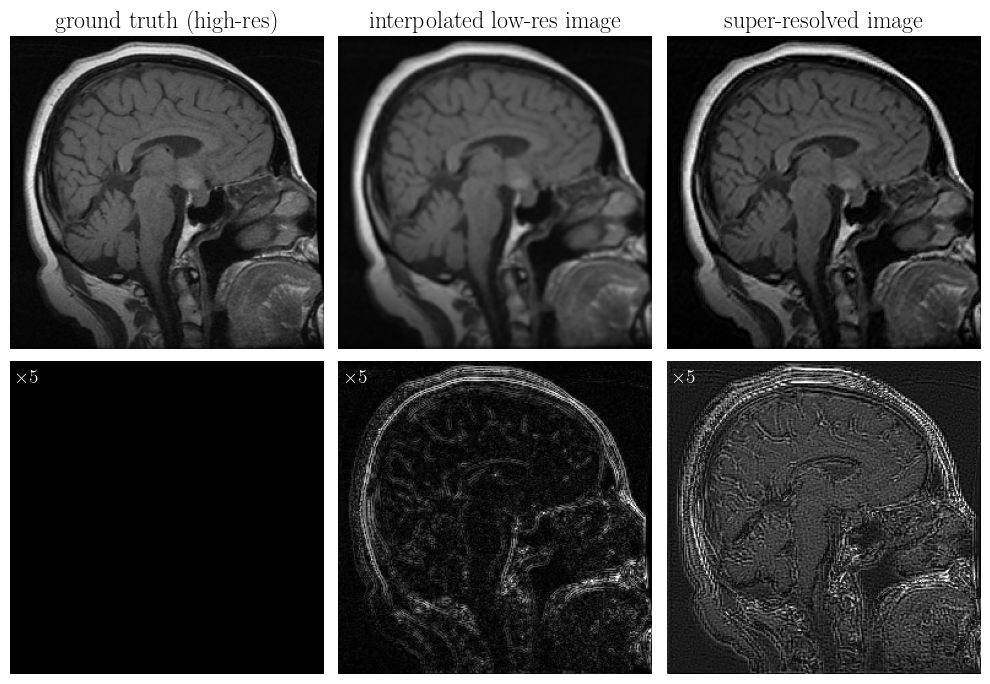

In [14]:
# Create the dataset for validation images
val_dataset = TIFFDataset('data/val/high-res', 'data/val/low-res', transform=transform)

# Load one (low-res, high-res) image pair from validation dataset and move it to the dedvice
val_low_res, val_high_res = val_dataset[1]  # Input (128x128), Ground truth (256x256)
val_low_res, val_high_res = val_low_res.to(device), val_high_res.to(device)

# Upsample low-resolution image to 256x256 for both model input and error visualization
# val_low_res_interpolated = torch.nn.functional.interpolate(val_low_res.unsqueeze(0), scale_factor=2, mode='bicubic', align_corners=False).squeeze(0)
val_low_res_interpolated = torch.nn.functional.interpolate(val_low_res.unsqueeze(0).cpu(), scale_factor=2, mode='bicubic', align_corners=False).squeeze(0).to(device)

# Apply the trained model to super-resolve the interpolated low-res image
val_super_res = model(val_low_res_interpolated.unsqueeze(0)).detach().squeeze(0)  # Remove batch dimension

# Convert tensors to numpy for visualization
val_low_res_np = val_low_res_interpolated.squeeze().cpu().numpy()  # Use the interpolated version for error maps
val_high_res_np = val_high_res.squeeze().cpu().numpy()
val_super_res_np = val_super_res.squeeze().cpu().numpy()

# Plot an example image and error maps
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

# Plot images
ax[0, 0].imshow(val_high_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 0].set_title('ground truth (high-res)')
ax[0, 0].axis('off')

ax[0, 1].imshow(val_low_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 1].set_title('interpolated low-res image')
ax[0, 1].axis('off')

ax[0, 2].imshow(val_super_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 2].set_title('super-resolved image')
ax[0, 2].axis('off')

# Error maps
ax[1, 0].imshow(5 * np.abs(val_high_res_np - val_high_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 0].axis('off')
ax[1, 0].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 1].imshow(5 * np.abs(val_high_res_np - val_low_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 1].axis('off')
ax[1, 1].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 1].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 2].imshow(5 * np.abs(val_high_res_np - val_super_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 2].axis('off')
ax[1, 2].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')

plt.tight_layout()
plt.show()

### Compute PSNR and SSIM over the entire validation dataset

In [15]:
# Initialize metrics
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# Accumulators
total_psnr_interpolated = 0
total_psnr_super_resolved = 0
total_ssim_interpolated = 0
total_ssim_super_resolved = 0
num_samples = len(val_dataset)

# Loop over validation set
for i in range(num_samples):
    val_low_res, val_high_res = val_dataset[i]
    val_low_res, val_high_res = val_low_res.to(device), val_high_res.to(device)

    # Compute data range dynamically
    data_range = val_high_res.max() - val_high_res.min()
    ssim_metric.data_range = data_range

    # Upsample low-res image on CPU
    val_low_res_interpolated = torch.nn.functional.interpolate(
        val_low_res.unsqueeze(0).cpu(), scale_factor=2, mode='bicubic', align_corners=False).to(device)

    val_high_res = val_high_res.unsqueeze(0)  # Add batch dim
    val_super_res = model(val_low_res_interpolated).detach()

    # PSNR
    psnr_interp = psnr_metric(val_low_res_interpolated, val_high_res).item()
    psnr_sr = psnr_metric(val_super_res, val_high_res).item()

    # SSIM
    ssim_interp = ssim_metric(val_low_res_interpolated, val_high_res).item()
    ssim_sr = ssim_metric(val_super_res, val_high_res).item()

    # Accumulate
    total_psnr_interpolated += psnr_interp
    total_psnr_super_resolved += psnr_sr
    total_ssim_interpolated += ssim_interp
    total_ssim_super_resolved += ssim_sr

# Averages
avg_psnr_interp = total_psnr_interpolated / num_samples
avg_psnr_sr = total_psnr_super_resolved / num_samples
avg_ssim_interp = total_ssim_interpolated / num_samples
avg_ssim_sr = total_ssim_super_resolved / num_samples

# Print results
print(f'Average PSNR (interpolated): {avg_psnr_interp:.2f} dB')
print(f'Average PSNR (super-resolved): {avg_psnr_sr:.2f} dB')
print(f'Average SSIM (interpolated): {avg_ssim_interp:.4f}')
print(f'Average SSIM (super-resolved): {avg_ssim_sr:.4f}')


Average PSNR (interpolated): 30.81 dB
Average PSNR (super-resolved): 25.91 dB
Average SSIM (interpolated): 0.9056
Average SSIM (super-resolved): 0.6545
